# Song Popularity Prediction

<a id='table-of-contents'></a>
## Table of Contents
1. [Preparations](#preparations)
    1. [Import Libraries](#import-libraries)
    2. [Load Data](#load-data)
2. [Modelling](#modelling)
    1. [Pipeline Set-Up](#pipeline)
    2. [Model Baseline](#baseline)
    3. [Hyper-Parameter Optimization](#hyper-param-opt)
    4. [Best Model Cross-Validation](#best-model-cv)
    5. [Feature Importance](#feat-imp)
3. [Predictions](#predictions)

<a id='preparations'></a>
## **1.** Preparations

[Back to Table of Contents](#table-of-contents)

<a id='import-libraries'></a>
### **1.1.** Import Libraries

[Back to Table of Contents](#table-of-contents)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.model_selection import PredefinedSplit, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16,7)
plt.style.use('ggplot')

/home/jbel/miniconda3/envs/ml-model/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


<a id='load-data'></a>
### **1.2.** Load Data

[Back to Table of Contents](#table-of-contents)

In [2]:
data_path = Path('./data')
train = pd.read_csv(data_path/'train.csv', index_col='id')
train[['key', 'audio_mode', 'time_signature']] = train[['key', 'audio_mode', 'time_signature']].astype('category')

<a id='modelling'></a>
## **2.** Modelling

[Back to Table of Contents](#table-of-contents)

In [3]:
X = train.drop(labels='song_popularity', axis=1)
y = train['song_popularity'].astype('int64')

# separate categorical and numerical columns
invsig_cols = [
    'acousticness', 'danceability', 'energy', 'instrumentalness', 
    'liveness', 'speechiness', 'audio_valence'
]
pow_cols = ['song_duration_ms', 'tempo']
cat_cols = X.select_dtypes(include='category').columns

In [4]:
SEED = 16

<a id='pipeline'></a>
### **2.1.** Pipeline Set-Up

[Back to Table of Contents](#table-of-contents)

In [5]:
# Transformations
inv_sigmoid = Pipeline(steps=[
    ('0', MinMaxScaler(feature_range=(1e-3, 1-1e-3))),
    ('1', FunctionTransformer(lambda x: np.log(x / (1-x)))),
    ('2', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Data Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('inv_sigmoid', inv_sigmoid, invsig_cols),
    ('scale', PowerTransformer(method='yeo-johnson', standardize=True), pow_cols),
    ('db_to_num', FunctionTransformer(lambda x: np.log1p(-x)), ['loudness'])
], remainder='passthrough')

# transformation Pipeline
transform_pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('imputer', IterativeImputer(sample_posterior=False, 
                                 max_iter=100, 
                                 initial_strategy='median', 
                                 random_state=SEED))
])

<a id='baseline'></a>
### **2.2.** Model Baseline

[Back to Table of Contents](#table-of-contents)

In [6]:
def generate_dmatrix(features, target, pipeline=None, no_pipe_fit=False, enable_categorical=True):
    """
    
    Generate xgboost DMatrix from features and target variables.
    
    ------------
    
    Args:
    
    ------------
    
        - features (pandas.DataFrame): DataFrame containing features to train on.
        - target (numpy.array or pandas.Series): target labels for each example.
        - pipeline (sklearn.pipeline.Pipeline, optional): scikit-learn transformation pipeline. Defaults to None.
        - no_pipe_fit (bool, optional): flag to indicate whether to use transform or fit_transform on the features while preprocessing using the pipeline. Defaults to False.
        - enable_categorical (bool, optional): enables categorical flag for DMatrix for category dtype series. Defaults to True.
    
    ------------
    
    Returns:
    
    ------------
    
        xgboost.DMatrix
    """
    if pipeline is not None:
        if no_pipe_fit:
            preprocessed = pd.DataFrame(transform_pipe.transform(features),
                                        columns=features.columns)
        else:
            preprocessed = pd.DataFrame(transform_pipe.fit_transform(features),
                                        columns=features.columns)
        dmatrix = xgb.DMatrix(preprocessed,
                              label=target,
                              enable_categorical=[True if enable_categorical else False][0],
                              feature_names=preprocessed.columns.to_list())
    else:
        dmatrix = xgb.DMatrix(features,
                              label=target,
                              enable_categorical=[True if enable_categorical else False][0],
                              feature_names=features.columns.to_list())

    return dmatrix

def make_folds(features, stratify, n_splits=5):
    """
    Generates Predefined Split to be used in cross-validation based on the
    provided features and labels to stratify on.

    ------------
    
    Args:
    
    ------------
    
        - features (pandas.DataFrame): DataFrame containing features to train on.
        - stratify (numpy.array or pandas.Series): labels to stratify on.
        - n_splits (int, optional): Number of splits or folds to create. Defaults to 5.

    ------------
    
    Returns:
    
    ------------
    
        sklearn.model_selection.PredefinedSplit
    """
    strat_folds = StratifiedKFold(n_splits=n_splits,
                                  shuffle=True,
                                  random_state=SEED)

    cv_fold = np.empty([len(features), 1], dtype=np.int32)

    for i, (_, test_index) in enumerate(strat_folds.split(features, stratify)):
        cv_fold[test_index] = i

    return PredefinedSplit(cv_fold)


def cv_xgb(dataset, model_params, cv_params, fit_model=False):
    """
    Performs cross-validation with the given dataset and model / cv parameters.

    ------------
    
    Args:
    
    ------------
    
        dataset (xgboost.DMatrix): data to be trained on.
        model_params (dict): booster parameters.
        cv_params (dict): cross-validation parameters.
        fit_model (bool, optional): flag to allow for training of model using the provided model parameters. Defaults to False.

    ------------
    
    Returns:
    
    ------------
    
        - history (pandas.DataFrame): contains history of eval metric mean and std across all boosting rounds.
        - model (xgboost.Booster, optional): trained booster based on model parameters. Only upon passing fit_model=True.
    """
    history = xgb.cv(model_params, dataset, **cv_params)

    mean_auc = history['test-auc-mean'].values[-1]
    std_auc = history['test-auc-std'].values[-1]

    print(f'\nAUC: {round(mean_auc, 5)} (+/- {round(std_auc, 5)})')

    plt.rcParams['figure.figsize'] = (16, 5)
    for i, col in enumerate(history[['train-auc-mean', 'test-auc-mean']].columns):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x=history.index, y=history[col])
        plt.title(col, weight='bold')
        plt.ylabel(' ')
        plt.xlabel(' ')
        plt.tight_layout()
    plt.subplot(1, 2, 2)
    plt.tight_layout()
    plt.show()

    if fit_model:
        model = xgb.train(model_params, dataset)
        return model, history
    else:
        return history

In [7]:
# add missing indicators
missing_ind = MissingIndicator(features='missing-only')
missing_values = missing_ind.fit_transform(X)
missing_values = pd.DataFrame(missing_values, index=X.index)

In [8]:
# stratify by categorical columns (except key due to cardinality), missing and target
col_strat = ['song_popularity', 'audio_mode', 'time_signature']

strat, _ = (
    train[['audio_mode', 'time_signature', 'song_popularity']]
    .join(missing_values.any(axis=1).rename('missing'))
    .astype('str')
    .apply(lambda row: '_'.join(row), axis=1)
    .factorize()
)
strat = pd.Series(strat, index=train.index)

In [9]:
# create a predefined split using the stratification
split = make_folds(X, strat)

In [10]:
# create xgboost DMatrix from preprocessed features and target
dtrain = generate_dmatrix(X, y, pipeline=transform_pipe, no_pipe_fit=False, enable_categorical=True)

[0]	train-auc:0.59228+0.00314	test-auc:0.54585+0.00365
[50]	train-auc:0.82655+0.00393	test-auc:0.55081+0.00569
[99]	train-auc:0.90750+0.00235	test-auc:0.54558+0.00345

AUC: 0.54558 (+/- 0.00345)


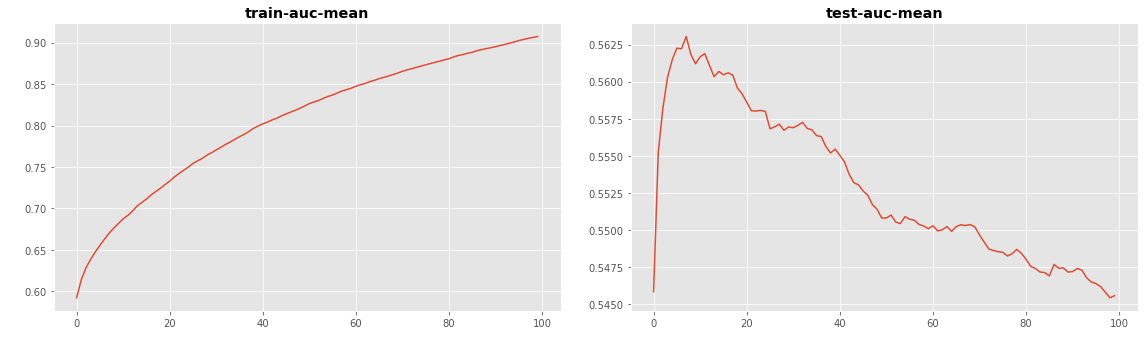

In [11]:
label_weight = y[y == 0].count() / y[y == 1].count()

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'booster': 'gbtree',
    'scale_pos_weight': label_weight
}

cv_params = {
    'maximize': True,
    'stratified': True,
    'num_boost_round': 100,
    'folds': split,
    'seed': SEED,
    'verbose_eval': 50
}

history = cv_xgb(dataset=dtrain, model_params=base_params, cv_params=cv_params)

<a id='hyper-param-opt'></a>
### **3.2.** Hyper-Parameter Optimization

[Back to Table of Contents](#table-of-contents)

In [12]:
def objective(trial, dmatrix=dtrain, cv=split):

    params = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'gpu_hist',
        'use_label_encoder': False,
        'seed': SEED,
        'scale_pos_weight': label_weight,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 75, 250),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'max_bin': trial.suggest_int('max_bin', 256, 512)
    }

    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        params['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'test-auc')
    history = xgb.cv(params,
                     dmatrix,
                     num_boost_round=params['n_estimators'],
                     callbacks=[pruning_callback],
                     folds=cv,
                     maximize=True)
    mean_auc = history['test-auc-mean'].values[-1]

    return mean_auc

In [13]:
pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(n_startup_trials=15, seed=SEED)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=200)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  AUC: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2022-03-11 18:05:27,342] A new study created in memory with name: no-name-4e924c6f-52e8-46e5-8ed0-37829dedf9d0
[I 2022-03-11 18:06:49,534] Trial 0 finished with value: 0.5639712 and parameters: {'booster': 'dart', 'lambda': 0.00025445538877080223, 'alpha': 2.3164109063979548e-08, 'n_estimators': 138, 'max_depth': 3, 'eta': 0.0032345159313967456, 'gamma': 2.0410394546914868e-07, 'grow_policy': 'lossguide', 'subsample': 0.7818406901174126, 'sampling_method': 'gradient_based', 'colsample_bytree': 0.5792260867615833, 'colsample_bylevel': 0.6251406533720116, 'max_bin': 331, 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.268938750029058e-08, 'skip_drop': 0.21953110426775624}. Best is trial 0 with value: 0.5639712.
[I 2022-03-11 18:06:58,023] Trial 1 finished with value: 0.5758700000000001 and parameters: {'booster': 'gbtree', 'lambda': 3.2849699202736395e-06, 'alpha': 2.21679655515907e-08, 'n_estimators': 207, 'max_depth': 5, 'eta': 0.013725349299402927, 'gamma': 0.0

Number of finished trials: 200
Best trial:
  AUC: 0.5758700000000001
  Params: 
    booster: gbtree
    lambda: 3.2849699202736395e-06
    alpha: 2.21679655515907e-08
    n_estimators: 207
    max_depth: 5
    eta: 0.013725349299402927
    gamma: 0.02106639047304049
    grow_policy: lossguide
    subsample: 0.5266496691721235
    sampling_method: uniform
    colsample_bytree: 0.7339980736899805
    colsample_bylevel: 0.8305296673824798
    max_bin: 433


<a id='best-model-cv'></a>
### **3.3.** Best Model Cross-Validation

[Back to Table of Contents](#table-of-contents)

Best Model Params
  verbosity: 0
  objective: binary:logistic
  eval_metric: auc
  tree_method: gpu_hist
  use_label_encoder: False
  seed: 16
  scale_pos_weight: 1.7442371020856202
  booster: gbtree
  lambda: 3.2849699202736395e-06
  alpha: 2.21679655515907e-08
  n_estimators: 207
  max_depth: 5
  eta: 0.013725349299402927
  gamma: 0.02106639047304049
  grow_policy: lossguide
  subsample: 0.5266496691721235
  sampling_method: uniform
  colsample_bytree: 0.7339980736899805
  colsample_bylevel: 0.8305296673824798
  max_bin: 433

CV Iterations:
[0]	train-auc:0.56102+0.00383	test-auc:0.54066+0.00218
[50]	train-auc:0.62641+0.00124	test-auc:0.57081+0.00569
[100]	train-auc:0.63762+0.00096	test-auc:0.57363+0.00548
[150]	train-auc:0.64735+0.00103	test-auc:0.57496+0.00538
[200]	train-auc:0.65646+0.00128	test-auc:0.57578+0.00535
[206]	train-auc:0.65756+0.00122	test-auc:0.57587+0.00532

AUC: 0.57587 (+/- 0.00532)


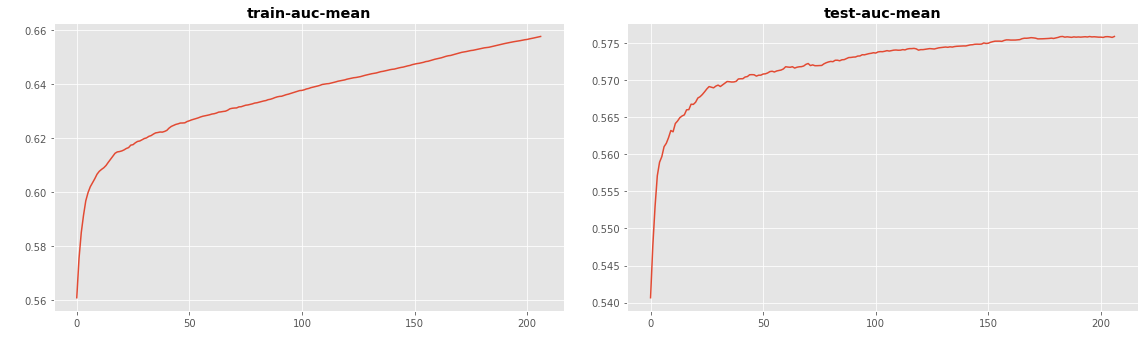

In [14]:
fixed_params = {
    'verbosity': 0,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'use_label_encoder': False,
    'seed': SEED,
    'scale_pos_weight': label_weight
}

best_params = fixed_params | study.best_params

print('Best Model Params')
for param, value in best_params.items():
    print('  {}: {}'.format(param, value))
print('\nCV Iterations:')

cv_params = {
    'maximize': True,
    'stratified': True,
    'num_boost_round': best_params['n_estimators'],
    'folds': split,
    'seed': SEED,
    'verbose_eval': 50
}

optclf, history = cv_xgb(dataset=dtrain, model_params=best_params, cv_params=cv_params, fit_model=True)

<a id='feat-imp'></a>
### **3.4.** Feature Importance

[Back to Table of Contents](#table-of-contents)

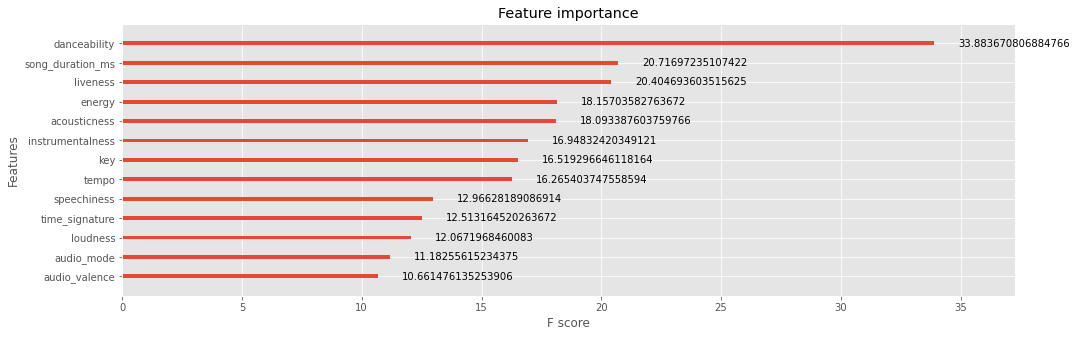

In [15]:
importance_type = 'gain'
xgb.plot_importance(optclf, importance_type=importance_type)
plt.show()

In [16]:
def cv_feature_importance(features, target, booster, model_params, cv_params, pipeline=None, importance_type=importance_type):
    """
    Performs cross-validation on the given features and target variable using feature importance scores,
    looping over subsets of columns based on different thresholds.

    ------------
    
    Args:
    
    ------------
    
        - features (pandas.DataFrame): DataFrame containing features to train on.
        - target (numpy.array or pandas.Series): target labels for each example.
        - booster (xgboost.Booster): pre-trained booster to get the feature importance scores from.
        - model_params (dict): booster parameters.
        - cv_params (dict): cross-validation parameters.
        - pipeline (sklearn.pipeline.Pipeline, optional): scikit-learn transformation pipeline. Defaults to None.
        - importance_type (str, optional): measure used to calculate importance scores. Defaults to 'gain'.
    """
    ft_imp = booster.get_score(importance_type=importance_type)
    thresholds = np.sort(list(ft_imp.values()))

    for thresh in thresholds:
        cols = [col for col, value in ft_imp.items() if value >= thresh]
        dtrain = generate_dmatrix(features[cols], target, pipeline=pipeline, no_pipe_fit=False, enable_categorical=True)
        print('Threshold=%.3f, Number of Features=%d' % (thresh, len(cols)))
        _ = cv_xgb(dataset=dtrain,
                   model_params=model_params,
                   cv_params=cv_params)

Threshold=10.661, Number of Features=13
[0]	train-auc:0.56102+0.00383	test-auc:0.54066+0.00218
[50]	train-auc:0.62641+0.00124	test-auc:0.57081+0.00569
[100]	train-auc:0.63762+0.00096	test-auc:0.57363+0.00548
[150]	train-auc:0.64735+0.00103	test-auc:0.57496+0.00538
[200]	train-auc:0.65646+0.00128	test-auc:0.57578+0.00535
[206]	train-auc:0.65756+0.00122	test-auc:0.57587+0.00532

AUC: 0.57587 (+/- 0.00532)


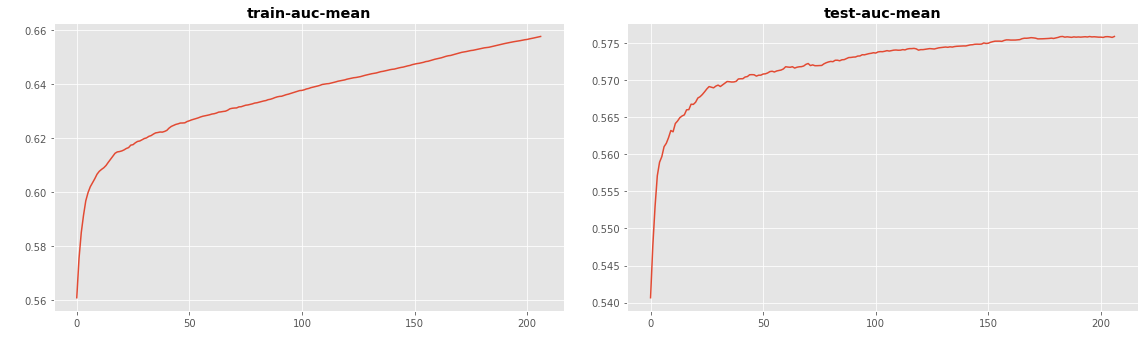

Threshold=11.183, Number of Features=12
[0]	train-auc:0.55078+0.00493	test-auc:0.53675+0.00476
[50]	train-auc:0.62378+0.00182	test-auc:0.57071+0.00631
[100]	train-auc:0.63581+0.00143	test-auc:0.57385+0.00565
[150]	train-auc:0.64578+0.00121	test-auc:0.57461+0.00576
[200]	train-auc:0.65508+0.00097	test-auc:0.57532+0.00466
[206]	train-auc:0.65606+0.00083	test-auc:0.57541+0.00468

AUC: 0.57541 (+/- 0.00468)


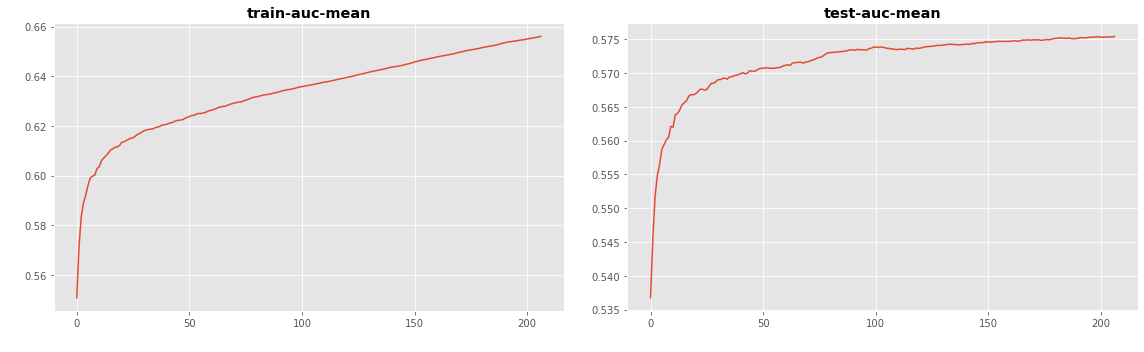

Threshold=12.067, Number of Features=11
[0]	train-auc:0.55933+0.00184	test-auc:0.54101+0.00580
[50]	train-auc:0.62021+0.00132	test-auc:0.57100+0.00699
[100]	train-auc:0.63127+0.00178	test-auc:0.57244+0.00688
[150]	train-auc:0.64056+0.00168	test-auc:0.57385+0.00627
[200]	train-auc:0.64961+0.00181	test-auc:0.57423+0.00605
[206]	train-auc:0.65072+0.00169	test-auc:0.57414+0.00613

AUC: 0.57414 (+/- 0.00613)


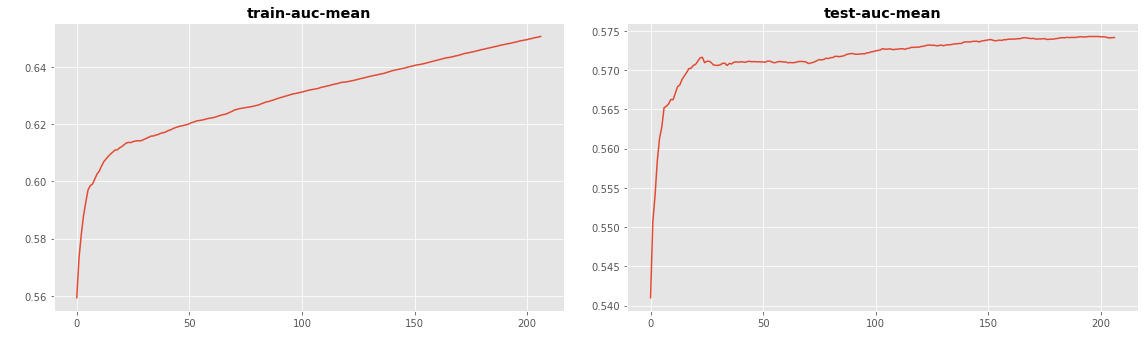

Threshold=12.513, Number of Features=10
[0]	train-auc:0.55555+0.00399	test-auc:0.54007+0.00774
[50]	train-auc:0.61674+0.00235	test-auc:0.56777+0.00717
[100]	train-auc:0.62650+0.00246	test-auc:0.56949+0.00781
[150]	train-auc:0.63501+0.00230	test-auc:0.57085+0.00773
[200]	train-auc:0.64339+0.00217	test-auc:0.57112+0.00810
[206]	train-auc:0.64431+0.00196	test-auc:0.57108+0.00796

AUC: 0.57108 (+/- 0.00796)


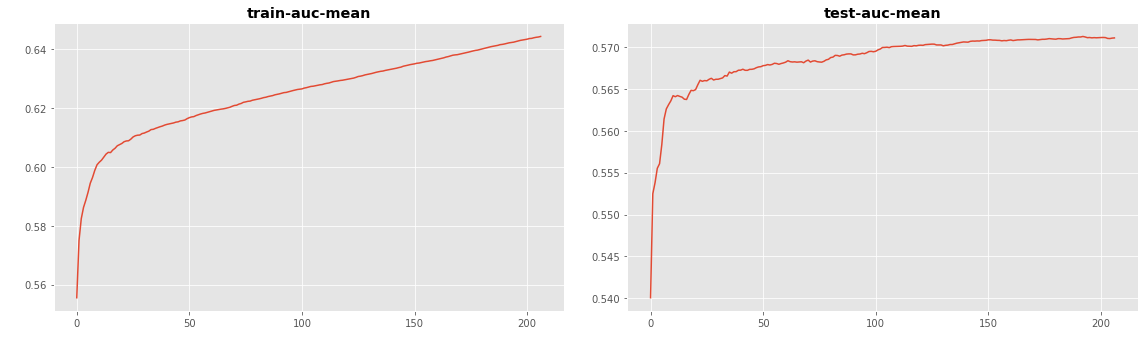

Threshold=12.966, Number of Features=9
[0]	train-auc:0.55218+0.00263	test-auc:0.53607+0.00848
[50]	train-auc:0.61451+0.00134	test-auc:0.56638+0.00707
[100]	train-auc:0.62553+0.00145	test-auc:0.56886+0.00676
[150]	train-auc:0.63395+0.00105	test-auc:0.56990+0.00694
[200]	train-auc:0.64233+0.00109	test-auc:0.57026+0.00685
[206]	train-auc:0.64331+0.00116	test-auc:0.57032+0.00681

AUC: 0.57032 (+/- 0.00681)


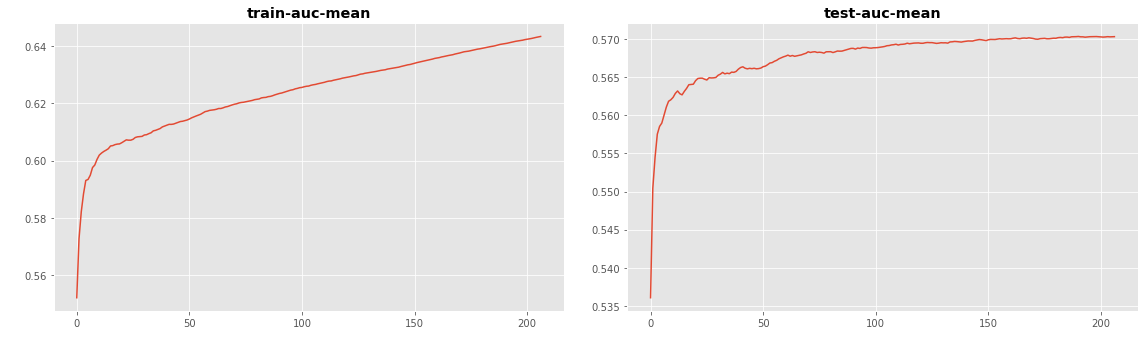

Threshold=16.265, Number of Features=8
[0]	train-auc:0.55163+0.00233	test-auc:0.53173+0.00351
[50]	train-auc:0.61589+0.00242	test-auc:0.56801+0.00720
[100]	train-auc:0.62535+0.00220	test-auc:0.57022+0.00723
[150]	train-auc:0.63299+0.00175	test-auc:0.57003+0.00752
[200]	train-auc:0.64067+0.00153	test-auc:0.57032+0.00685
[206]	train-auc:0.64165+0.00149	test-auc:0.57035+0.00694

AUC: 0.57035 (+/- 0.00694)


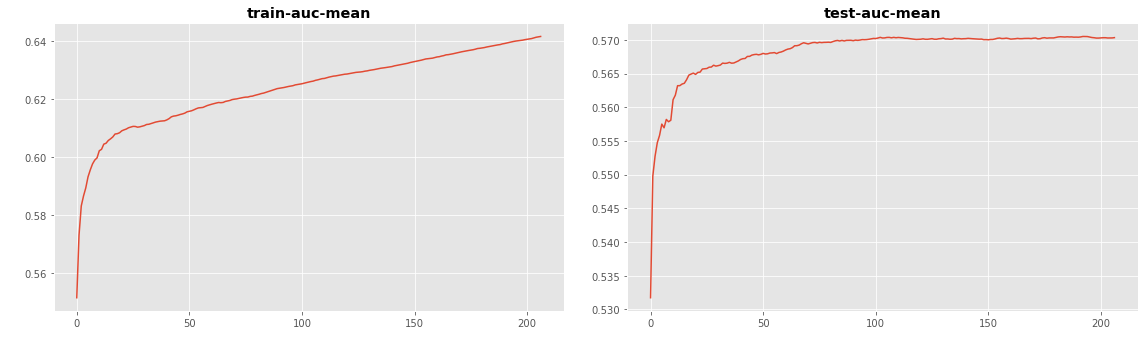

Threshold=16.519, Number of Features=7
[0]	train-auc:0.55332+0.00231	test-auc:0.53498+0.01023
[50]	train-auc:0.61275+0.00235	test-auc:0.56577+0.00626
[100]	train-auc:0.62239+0.00161	test-auc:0.56760+0.00617
[150]	train-auc:0.63000+0.00191	test-auc:0.56817+0.00651
[200]	train-auc:0.63803+0.00180	test-auc:0.56806+0.00629
[206]	train-auc:0.63900+0.00168	test-auc:0.56825+0.00644

AUC: 0.56825 (+/- 0.00644)


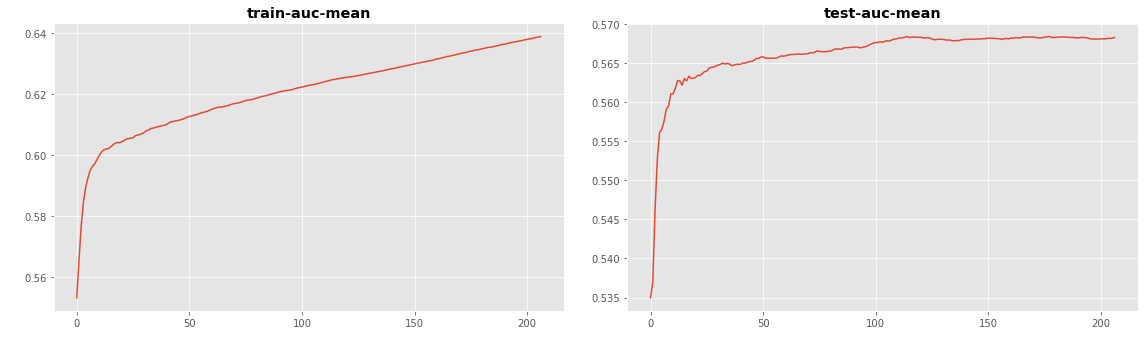

Threshold=16.948, Number of Features=6
[0]	train-auc:0.55917+0.00409	test-auc:0.54457+0.00405
[50]	train-auc:0.60901+0.00175	test-auc:0.56578+0.00739
[100]	train-auc:0.61762+0.00187	test-auc:0.56679+0.00654
[150]	train-auc:0.62449+0.00194	test-auc:0.56704+0.00606
[200]	train-auc:0.63190+0.00181	test-auc:0.56680+0.00572
[206]	train-auc:0.63282+0.00172	test-auc:0.56677+0.00582

AUC: 0.56677 (+/- 0.00582)


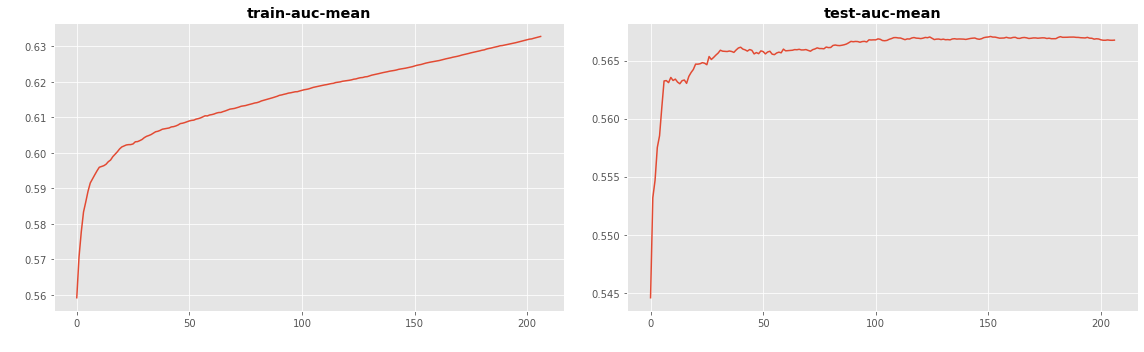

Threshold=18.093, Number of Features=5
[0]	train-auc:0.55201+0.00118	test-auc:0.54054+0.00487
[50]	train-auc:0.60234+0.00085	test-auc:0.56114+0.00459
[100]	train-auc:0.61113+0.00112	test-auc:0.56228+0.00552
[150]	train-auc:0.61806+0.00107	test-auc:0.56157+0.00640
[200]	train-auc:0.62493+0.00076	test-auc:0.56157+0.00633
[206]	train-auc:0.62581+0.00085	test-auc:0.56164+0.00648

AUC: 0.56164 (+/- 0.00648)


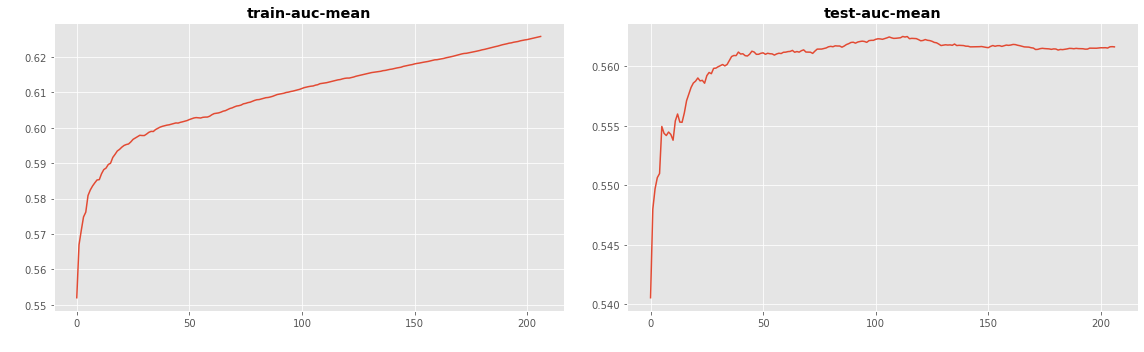

Threshold=18.157, Number of Features=4
[0]	train-auc:0.54515+0.00258	test-auc:0.53131+0.00113
[50]	train-auc:0.59234+0.00132	test-auc:0.55560+0.00534
[100]	train-auc:0.59895+0.00170	test-auc:0.55692+0.00610
[150]	train-auc:0.60501+0.00151	test-auc:0.55678+0.00609
[200]	train-auc:0.61030+0.00161	test-auc:0.55700+0.00635
[206]	train-auc:0.61086+0.00161	test-auc:0.55705+0.00640

AUC: 0.55705 (+/- 0.0064)


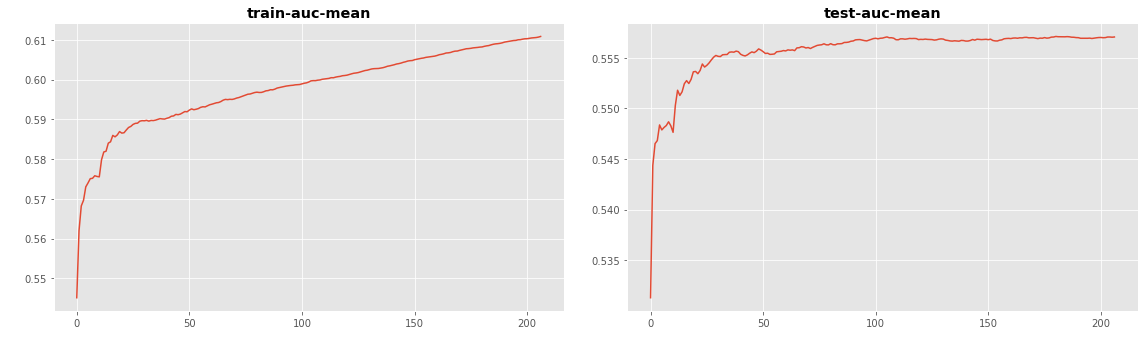

Threshold=20.405, Number of Features=3
[0]	train-auc:0.53770+0.00206	test-auc:0.52262+0.00632
[50]	train-auc:0.58046+0.00132	test-auc:0.54730+0.00327
[100]	train-auc:0.58703+0.00151	test-auc:0.54748+0.00419
[150]	train-auc:0.59280+0.00148	test-auc:0.54712+0.00458
[200]	train-auc:0.59838+0.00116	test-auc:0.54656+0.00381
[206]	train-auc:0.59907+0.00124	test-auc:0.54661+0.00377

AUC: 0.54661 (+/- 0.00377)


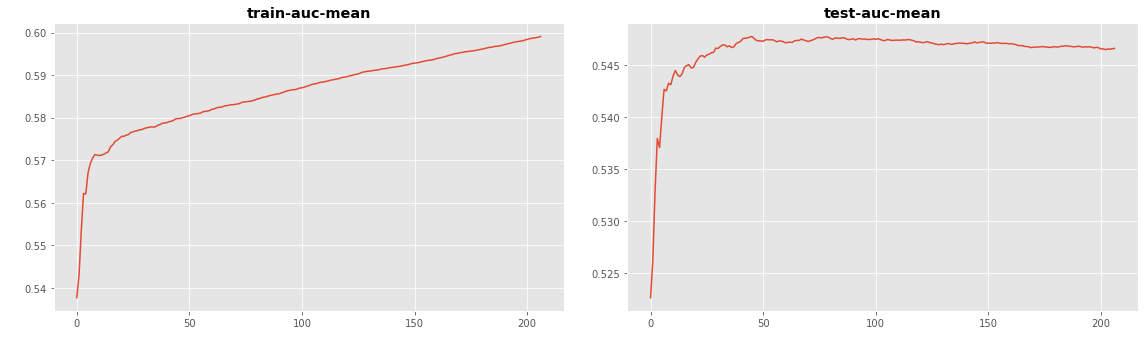

Threshold=20.717, Number of Features=2
[0]	train-auc:0.54159+0.00177	test-auc:0.53188+0.00541
[50]	train-auc:0.56741+0.00174	test-auc:0.53964+0.00505
[100]	train-auc:0.57116+0.00176	test-auc:0.53948+0.00515
[150]	train-auc:0.57402+0.00168	test-auc:0.53937+0.00575
[200]	train-auc:0.57662+0.00146	test-auc:0.53934+0.00546
[206]	train-auc:0.57707+0.00152	test-auc:0.53931+0.00555

AUC: 0.5393 (+/- 0.00555)


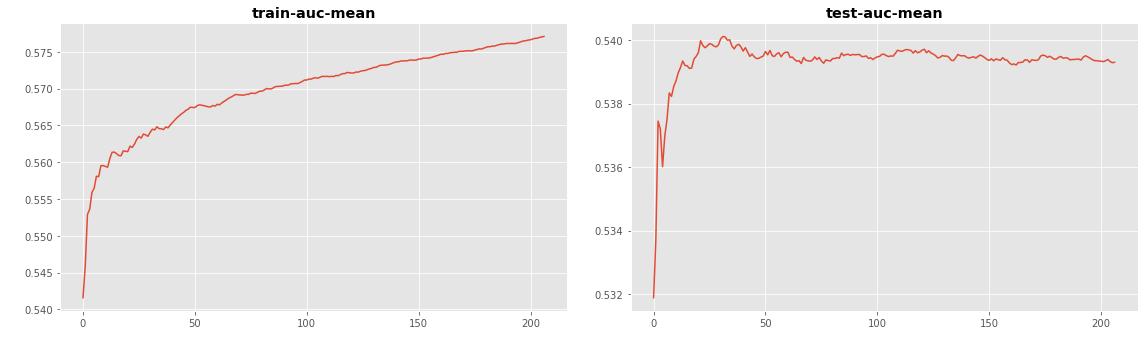

Threshold=33.884, Number of Features=1
[0]	train-auc:0.54159+0.00177	test-auc:0.53188+0.00541
[50]	train-auc:0.55593+0.00076	test-auc:0.53588+0.00459
[100]	train-auc:0.55880+0.00085	test-auc:0.53572+0.00476
[150]	train-auc:0.56104+0.00078	test-auc:0.53558+0.00482
[200]	train-auc:0.56308+0.00075	test-auc:0.53532+0.00478
[206]	train-auc:0.56336+0.00079	test-auc:0.53514+0.00492

AUC: 0.53514 (+/- 0.00492)


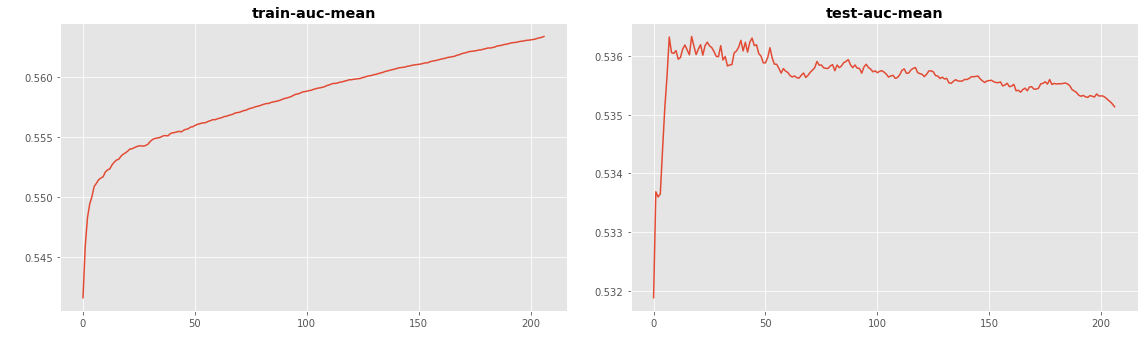

In [17]:
preprocessed = pd.DataFrame(transform_pipe.fit_transform(X), columns=X.columns)
cv_feature_importance(preprocessed, y, optclf, best_params, cv_params, pipeline=None)

From these results, it is possible to see that the performance of the model generally decreases with the number of selected features.

On this problem there is a trade-off of features to test set AUC-ROC score and we could decide to take a less complex model (fewer attributes such as n=8) and accept a modest decrease in estimated AUC-ROC score from 0.57587 down to 0.57035.

This is not likely to yield significant results on such a small dataset, but may be a more useful strategy on a larger dataset using cross validation as the model evaluation scheme.

In [18]:
# Save best model
optclf.save_model('best_model.json')

<a id='predictions'></a>
### **4.** Predictions

[Back to Table of Contents](#table-of-contents)

In [19]:
# Load best model
model = xgb.Booster(model_file='best_model.json')

# Load and preprocess test dataset
test = pd.read_csv(data_path/'test.csv', index_col='id')
preproc_test = generate_dmatrix(features=test, target=None, pipeline=transform_pipe, no_pipe_fit=True, enable_categorical=True)

# Perform predictions and save to csv
predictions = model.predict(preproc_test)
predictions = pd.DataFrame(predictions, columns=[
    'song_popularity'
]).song_popularity.map(lambda x: 1 if x > 0.5 else 0)
predictions.to_csv('./predictions/predictions.csv', index_label='id')